In [395]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mnist_utils as mu
import random
import pyNN.nest as p
import relu_utils as alg
import spiking_relu as sr

In [396]:
def plot_spikes(spikes, title):
    if spikes is not None:
        fig, ax = plt.subplots()
        #plt.figure(figsize=(15, 5))
        ax.plot([i[1] for i in spikes], [i[0] for i in spikes], ".")
        plt.xlabel('Time/ms')
        plt.ylabel('spikes')
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        plt.title(title)

    else:
        print "No spikes received"
    plt.show()

In [397]:
input_size = 28
num_output = 500
SUM_rate = 2000.
dur_test = 500
input_time = 40.
dbnet = alg.load_dict('dig_5_greedy_b10_epoc5')
w = np.copy(dbnet['layer'][0]['w'])

In [398]:
pos_w = np.copy(w)
pos_w[pos_w < 0] = 0
neg_w = np.copy(w)
neg_w[neg_w > 0] = 0

cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 1.,   
                   'tau_syn_E': 1.0,
                   'tau_syn_I': 1.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

test_x,test_y = mu.get_test_data()
num_test = 1
select = 0
ind = np.where(test_y==5)[0][select:select+num_test]
observe = 0

In [399]:
test0 = test_x[ind[observe]]
test0 = test0/sum(test0)*SUM_rate
k = 167.6
x0 = 0.1
y0 = 4.48
x_lim = sr.rev_transf(k, x0, y0, 50.) #50 Hz as max output rate
w = np.copy(dbnet['layer'][0]['w'])
curr = alg.ReLU(test0, w)

scale1 = x_lim * 1000. / (np.mean(curr)+3*np.std(curr))#max(curr)
curr *= scale1/1000.
out_rate = sr.transf(k, x0, y0, curr)
print scale1#, max(curr), max(out_rate)

hid = alg.ReLU(test0, w*scale1)
hid = sr.transf(k, x0, y0, hid/1000.) 
curr = alg.ReLU(hid, np.transpose(w))
x_lim = sr.rev_transf(k, x0, y0, 30.) #10 Hz as max output rate
scale2 = x_lim * 1000. / (np.mean(curr)+3*np.std(curr))#max(curr)
curr *= scale2/1000.
out_rate = sr.transf(k, x0, y0, curr)

print scale2

19.8885294484
7.14826957457


In [400]:
p.setup(timestep=1.0, min_delay=1.0, max_delay=3.0)
random.seed(0)
spike_source_data = mu.mnist_poisson_gen(test_x[ind], input_size, input_size, SUM_rate, input_time, 0)

In [401]:
pop_poisson = p.Population(input_size*input_size, p.SpikeSourceArray, {'spike_times' : []})
for j in range(input_size*input_size):
    pop_poisson[j].spike_times = spike_source_data[j]
pop_vis = p.Population(input_size*input_size, p.IF_curr_exp, cell_params_lif)
p.Projection(pop_poisson, pop_vis, p.OneToOneConnector(weights = 6.), target='excitatory')
pop_up = p.Population(num_output, p.IF_curr_exp, cell_params_lif)
p.Projection(pop_vis, pop_up, p.AllToAllConnector(weights = pos_w * scale1), target='excitatory')
p.Projection(pop_vis, pop_up, p.AllToAllConnector(weights = neg_w * scale1), target='inhibitory')
p.Projection(pop_up, pop_vis, p.AllToAllConnector(weights = np.transpose(pos_w * scale2)), target='excitatory')
p.Projection(pop_up, pop_vis, p.AllToAllConnector(weights = np.transpose(neg_w * scale2)), target='inhibitory')
#pop_output = p.Population(input_size*input_size, p.IF_curr_exp, cell_params_lif)
#p.Projection(pop_up, pop_output, p.AllToAllConnector(weights = np.transpose(pos_w * scale2)), target='excitatory')
#p.Projection(pop_up, pop_output, p.AllToAllConnector(weights = np.transpose(neg_w * scale2)), target='inhibitory')
pop_up.record()
pop_vis.record()
#pop_output.record()
p.run(dur_test)
spikes_h = pop_up.getSpikes(compatible_output=True)
spikes = pop_vis.getSpikes(compatible_output=True)
#spikes = pop_output.getSpikes(compatible_output=True)

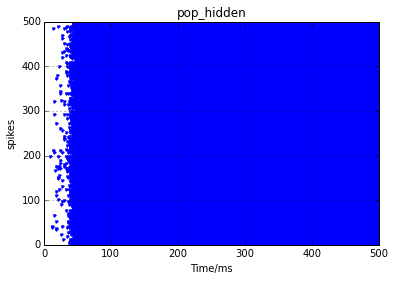

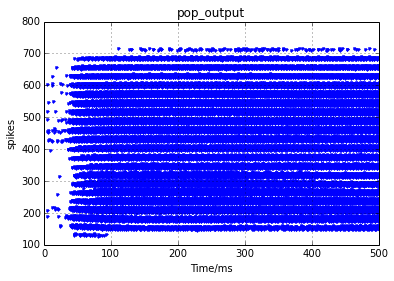

In [402]:
plot_spikes(spikes_h,'pop_hidden')
plot_spikes(spikes,'pop_output')

In [403]:
def counter(data, left_edge, dur):
    count = []
    for l in left_edge:
        temp = np.where((data >= l) & (data < l+dur))
        count.append(temp[0].shape[0])
    return count

In [404]:
spike_count = list()
for i in range(input_size * input_size):
    index_i = np.where(spikes[:,0] == i)
    spike_train = spikes[index_i, 1]
    #temp = np.histogram(spike_train, bins=range(0, (dur_test+silence)*num_test+1,dur_test+silence))[0]
    #temp = counter(spike_train, range(500, 501, dur_test), dur_test-500)
    temp = counter(spike_train, range(150, 151, 20), dur_test)
    spike_count.append(temp)
spike_count = np.array(spike_count)/(dur_test / 1000.)

pike_train=[]
temp=[]
spike_h_count = list()
for i in range(num_output):
    index_i = np.where(spikes_h[:,0] == i)
    spike_train = spikes_h[index_i, 1]
    #temp = np.histogram(spike_train, bins=range(0, (dur_test+silence)*num_test+1,dur_test+silence))[0]
    temp = counter(spike_train, range(0, 1, dur_test), dur_test)
    spike_h_count.append(temp)
spike_h_count = np.array(spike_h_count)/(dur_test / 1000.)


79.9566326531


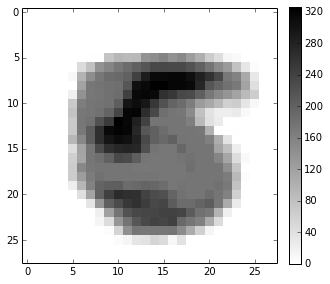

In [405]:
mu.plot_digit(spike_count[:,observe])
plt.savefig('dis_sampling.pdf')
print np.average(spike_count[:,observe])

maybe what I got during 1s is the converged samples!!! I think so!!! we can plot all the training data in a single image.

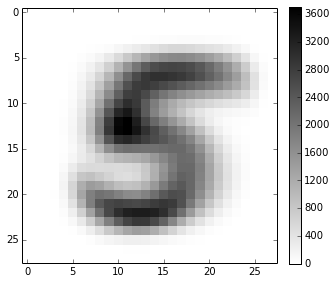

In [345]:
a = np.sum(Data_v,axis=0)
mu.plot_digit(a)
plt.savefig('add_up.pdf')

In [194]:
digit = 5
train_x,train_y = mu.get_train_data()
random.seed(0)
label_list = np.array(train_y).astype(int)
index_digit = np.where(label_list==digit)[0]
#index_digit = np.where(label_list>=0)[0]
train_num = len(index_digit)-1
index_train = index_digit[0:train_num]
Data_v = np.array(train_x[index_train]).astype(float)
Data_v = Data_v/255.
Labels = np.array(train_y[index_train]).astype(int)
Data_l = np.zeros((train_num, 10))
for i in range(train_num):
    Data_l[i, Labels[i]] = 1.

5


NameError: name 'neuron' is not defined

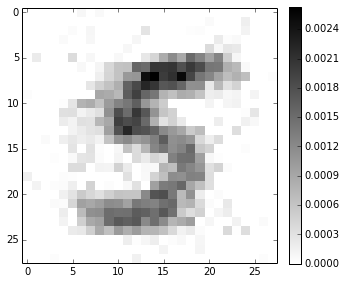

In [197]:
nodes = [784, 500, 500, 2000, 10]
bsize = 10
iteration = 5
dbnet = alg.init_label_dbn(Data_v, Data_l, nodes, eta=1e-3, batch_size=10, epoc=iteration)
train_data = dbnet['train_x']
batch_size = dbnet['batch_size']
dbnet['layer'][0] = alg.RBM_train(dbnet['layer'][0], dbnet['epoc'], batch_size, train_data)
dbnet['train_x']=[]
dbnet['train_y']=[]
#predict, recon = alg.greedy_recon(dbnet, Data_v[0])


In [198]:
dbn_file = 'dig_%d_greedy_b%d_epoc%d'%(digit,bsize, iteration)
alg.save_dict(dbnet, dbn_file)

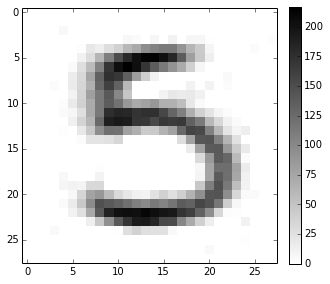

In [368]:
w=dbnet['layer'][0]['w']
temp = alg.ReLU(test_x[ind], w)
out = alg.ReLU(temp, np.transpose(w))
mu.plot_digit(out)

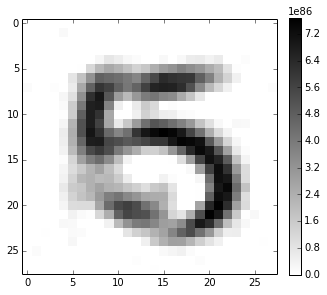

In [392]:
ind1 = np.where(test_y==5)[0]
temp = test_x[ind1[1]]
fantacy = np.zeros(784)
for i in range(10000):
    temp = alg.ReLU(temp, w)
    temp = alg.ReLU(temp, np.transpose(w))
    fantacy += temp
mu.plot_digit(fantacy)
plt.savefig('gibbs10k.pdf')

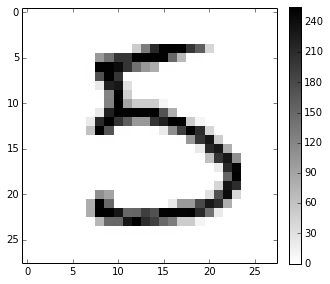

In [394]:
mu.plot_digit(test_x[ind1[1]])
plt.savefig('orin.pdf')